In [186]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [187]:
## Loading the dataset
path='/content/drive/My Drive/Company Stock and Investment.csv'
df=pd.read_csv(path)

In [188]:
df.head()

,Date,Oil Investments,Gold Investments,Comp Stock,Other sharesInvestments
0,31-12-2009,0.025417,0.000150,0.017354,0.006848
1,04-01-2010,0.026830,0.001097,0.015565,-0.004609
2,05-01-2010,0.002699,0.001560,0.001729,0.005900
3,06-01-2010,0.021688,0.006009,-0.015906,-0.018116
4,07-01-2010,-0.006256,0.000221,-0.001849,-0.017013


In [189]:
df=df.drop(['Oil Investments','Gold Investments','Other sharesInvestments'],axis=1)
df

,Date,Comp Stock
0,31-12-2009,0.017354
1,04-01-2010,0.015565
2,05-01-2010,0.001729
3,06-01-2010,-0.015906
4,07-01-2010,-0.001849
...,...,...
1979,09-11-2017,-0.002043
1980,10-11-2017,-0.006880
1981,13-11-2017,-0.004008
1982,14-11-2017,-0.015118


In [190]:
df['Date']=pd.to_datetime(df['Date'],format='%d-%m-%Y')
df.set_index('Date', inplace=True)

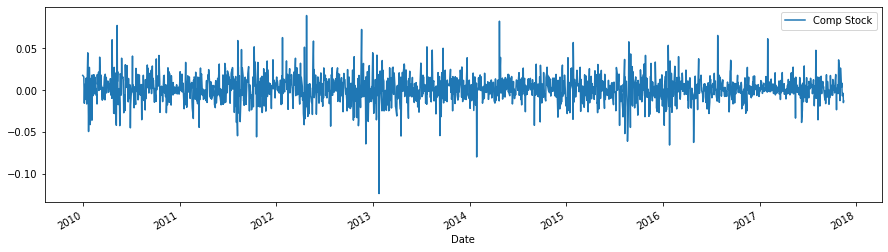

In [191]:
df.plot(figsize=(15,4))

In [192]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [193]:
print(df)

[[0.66374024]
 [0.65531476]
 [0.59014228]
 ...
 [0.56312197]
 [0.51079001]
 [0.519869  ]]


In [194]:
##splitting dataset into train and test split
training_size=int(len(df)*0.76)
test_size=len(df)-training_size
train_data,test_data=df[0:training_size,:],df[training_size:len(df),:1]

In [195]:
training_size,test_size

(1507, 477)

In [196]:
train_data

array([[0.66374024],
       [0.65531476],
       [0.59014228],
       ...,
       [0.5776102 ],
       [0.64261847],
       [0.55684457]])

In [197]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----29 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [198]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [199]:
print(X_train.shape), print(y_train.shape)

(1476, 30)
(1476,)


(None, None)

In [200]:
print(X_test.shape), print(ytest.shape)

(446, 30)
(446,)


(None, None)

In [201]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [202]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [203]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(30,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [204]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 30, 50)            10400     
_________________________________________________________________
lstm_16 (LSTM)               (None, 30, 50)            20200     
_________________________________________________________________
lstm_17 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [205]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
24/24 [==============================] - 1s 46ms/step - loss: 0.0469 - val_loss: 0.0087
Epoch 2/200
24/24 [==============================] - 0s 9ms/step - loss: 0.0087 - val_loss: 0.0037
Epoch 3/200
24/24 [==============================] - 0s 9ms/step - loss: 0.0065 - val_loss: 0.0035
Epoch 4/200
24/24 [==============================] - 0s 10ms/step - loss: 0.0063 - val_loss: 0.0035
Epoch 5/200
24/24 [==============================] - 0s 10ms/step - loss: 0.0067 - val_loss: 0.0034
Epoch 6/200
24/24 [==============================] - 0s 10ms/step - loss: 0.0065 - val_loss: 0.0039
Epoch 7/200
24/24 [==============================] - 0s 9ms/step - loss: 0.0067 - val_loss: 0.0034
Epoch 8/200
24/24 [==============================] - 0s 9ms/step - loss: 0.0064 - val_loss: 0.0034
Epoch 9/200
24/24 [==============================] - 0s 10ms/step - loss: 0.0063 - val_loss: 0.0038
Epoch 10/200
24/24 [==============================] - 0s 11ms/step - loss: 0.0070 - val_loss: 0.0035
Epo

In [206]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [207]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [208]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
mse = mean_squared_error(ytest,test_predict)
print('MSE: '+str(mse))
mae = mean_absolute_error(ytest,test_predict)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(ytest,test_predict))
print('RMSE: '+str(rmse))

MSE: 0.3524331308479299
MAE: 0.5908667328030326
RMSE: 0.5936607876960798


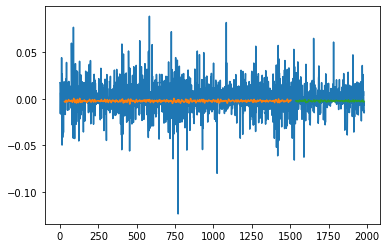

In [209]:
### Plotting 
# shift train predictions for plotting
look_back=30
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [210]:
len(test_data)

477

In [211]:
x_input=test_data[447:].reshape(1,-1)
x_input.shape

(1, 30)

In [212]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [213]:
temp_input

[0.6406171678973693,
 0.5792707608962954,
 0.5983770781131876,
 0.5838122687839893,
 0.6016380448750582,
 0.5654501226080281,
 0.6118914412685426,
 0.6687104148505201,
 0.5993810710041303,
 0.5611577582502952,
 0.4705500929743946,
 0.5901524683226481,
 0.5795870549029382,
 0.610049296815432,
 0.5613104671766436,
 0.6121140844771085,
 0.7507699177093894,
 0.6880209107790232,
 0.6475454098504096,
 0.5220888233495548,
 0.6164323415235562,
 0.7050036695361499,
 0.6297847729247469,
 0.59713668784758,
 0.6205309605525241,
 0.5723771587163693,
 0.5495930010361975,
 0.5631219662172057,
 0.510790011415581,
 0.519869004568418]

In [214]:
# demonstrate prediction for next 2 years
from numpy import array

lst_output=[]
n_steps=30
i=0
while(i<775):
    
    if(len(temp_input)>30):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.5724728]
31
1 day input [0.57927076 0.59837708 0.58381227 0.60163804 0.56545012 0.61189144
 0.66871041 0.59938107 0.56115776 0.47055009 0.59015247 0.57958705
 0.6100493  0.56131047 0.61211408 0.75076992 0.68802091 0.64754541
 0.52208882 0.61643234 0.70500367 0.62978477 0.59713669 0.62053096
 0.57237716 0.549593   0.56312197 0.51079001 0.519869   0.57247281]
1 day output [[0.57500416]]
2 day input [0.59837708 0.58381227 0.60163804 0.56545012 0.61189144 0.66871041
 0.59938107 0.56115776 0.47055009 0.59015247 0.57958705 0.6100493
 0.56131047 0.61211408 0.75076992 0.68802091 0.64754541 0.52208882
 0.61643234 0.70500367 0.62978477 0.59713669 0.62053096 0.57237716
 0.549593   0.56312197 0.51079001 0.519869   0.57247281 0.57500416]
2 day output [[0.57744735]]
3 day input [0.58381227 0.60163804 0.56545012 0.61189144 0.66871041 0.59938107
 0.56115776 0.47055009 0.59015247 0.57958705 0.6100493  0.56131047
 0.61211408 0.75076992 0.68802091 0.64754541 0.52208882 0.61643234
 0.70500367 0.6297847

In [225]:
day_new=np.arange(1,30)
day_pred=np.arange(31,806)

In [226]:
len(df)

1984

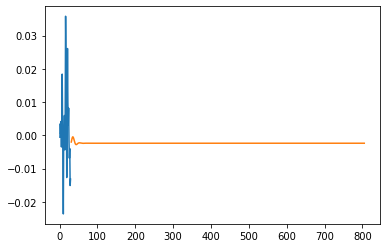

In [227]:
plt.plot(day_new,scaler.inverse_transform(df[1955:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

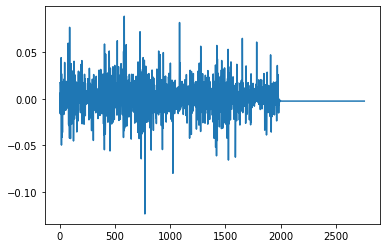

In [228]:
df3=df.tolist()
df3.extend(lst_output)
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)
